## ⚙️ Configuración del Entorno

**Entorno Virtual:** Este proyecto usa un entorno virtual `.venv` con las dependencias instaladas.

**Para ejecutar este notebook:**
1. Asegúrate de que VS Code esté usando el intérprete correcto:
   - Abre el Command Palette (`Cmd+Shift+P`)
   - Busca **"Python: Select Interpreter"**
   - Selecciona: `.venv/bin/python` (Python 3.13.2)

2. Selecciona el kernel correcto en el notebook:
   - Click en el selector de kernel (arriba a la derecha)
   - Selecciona el kernel **"Python 3.13 (Lab3 Finanzas)"**

**Paquetes instalados:**
- gurobipy 12.0.3 (optimizador)
- pandas 2.3.3
- numpy 2.3.4
- matplotlib 3.10.7
- seaborn 0.13.2
- scipy 1.15.2
- openpyxl 3.1.5

**Nota:** Se requiere una licencia académica de Gurobi (ya configurada).

---

# Maximizar Utilidad

El modelo estándar de portafolio de media-varianza (Markowitz) determina un portafolio de inversión óptimo que equilibra el riesgo y el rendimiento esperado


In [1]:
pip install gurobipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import gurobipy as gp
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

## Datos de Entrada

Los siguientes datos de entrada se utilizan en el modelo:

- $S$: conjunto de acciones
- $\mu$: vector de rendimientos esperados
- $\Sigma$: matriz de varianza-covarianza
    - $\sigma_{ij}$ covarianza entre los rendimientos de los activos $i$ y $j$
    - $\sigma_{ii}$ varianza del rendimiento del activo $i$

In [3]:
# Importar datos
Sigma = pd.read_pickle("sigma.pkl")
mu = pd.read_pickle("mu.pkl")

In [4]:
# Verificar los índices cargados
print(f"Número de índices: {len(mu)}")
print(f"Índices: {list(mu.index)}")
print(f"\nRetornos esperados:\n{mu}")
print(f"\nDimensiones de Sigma: {Sigma.shape}")

Número de índices: 8
Índices: ['AFPCAPITAL Cierre Ix', 'CEMENTOS Cierre Ix', 'CONCHATORO Cierre Ix', 'ENERSIS-AM Cierre Ix', 'INVERCAP Cierre Ix', 'MELON Cierre Ix', 'OXIQUIM Cierre Ix', 'SONDA Cierre Ix']

Retornos esperados:
AFPCAPITAL Cierre Ix    0.180531
CEMENTOS Cierre Ix      2.725361
CONCHATORO Cierre Ix    0.158847
ENERSIS-AM Cierre Ix    0.230292
INVERCAP Cierre Ix      0.479261
MELON Cierre Ix         0.638690
OXIQUIM Cierre Ix       2.387393
SONDA Cierre Ix         0.270434
dtype: float64

Dimensiones de Sigma: (8, 8)


## Formulación

El modelo maximiza el rendimiento esperado total para un nivel máximo de varianza (riesgo) preespecificado. Matemáticamente, esto resulta en un problema de optimización convexa con restricciones cuadráticas.

### Variables de Decisión y Cotas de las Variable

Las variables de decisión en el modelo son las proporciones de capital invertidas entre las acciones consideradas. El vector correspondiente de posiciones se denota por $x$, donde su componente $x_i$ representa la proporción de capital invertido en la acción $i$.

Cada posición debe estar entre 0 y 1; esto evita el apalancamiento y la venta en corto:

$$0\leq x_i\leq 1 \; , \;  i \in S$$


###  Restricciones
La restricción presupuestaria garantiza que todo el capital esté invertido:

$$\sum_{i \in S} x_i =1$$

El riesgo estimado debe ser, a lo más, igual al nivel de varianza admisible preespecificado $\bar\sigma^2$:

$$x^\top \Sigma x \leq \bar\sigma^2$$

###  Función Objetivo
El objetivo es maximizar el rendimiento esperado del portafolio:

$$\max_x \mu^\top x $$

Usando gurobipy, esto se puede expresar de la siguiente manera:

In [5]:
V = 30  # varianza (sigma^2)

# Crear un modelo de optimización vacío
m = gp.Model()

# Agregar variables: x[i] denota la proporción invertida en la acción i
# 0 <= x[i] <= 1
x = m.addMVar(len(mu), lb=0, ub=1, name="x")

# Restricción presupuestaria: todas las inversiones suman 1
m.addConstr(x.sum() == 1, name="Restriccion_Presupuesto")

# Límite en la varianza
restriccion_riesgo = m.addConstr(x @ Sigma.to_numpy() @ x <= V, name="restriccion_riesgo")

m.params.MIPGap = 0
m.params.NonConvex = 2

# Definir la función objetivo: Maximizar el rendimiento esperado
m.setObjective(mu.to_numpy() @ x, gp.GRB.MAXIMIZE)

Set parameter Username
Set parameter LicenseID to value 2670174
Academic license - for non-commercial use only - expires 2026-05-23
Set parameter LicenseID to value 2670174
Academic license - for non-commercial use only - expires 2026-05-23
Set parameter MIPGap to value 0
Set parameter NonConvex to value 2
Set parameter MIPGap to value 0
Set parameter NonConvex to value 2


Resolvemos:

In [6]:
m.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0
NonConvex  2

Optimize a model with 1 rows, 8 columns and 8 nonzeros
Model fingerprint: 0xe3310d25
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-01, 2e+02]
  Objective range  [2e-01, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
  QRHS range       [3e+01, 3e+01]

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0
NonConvex  2

Optimize a model with 1 rows, 8 columns and 8 nonzeros
Model fingerprint: 0xe3310d25
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-01, 2e+02]
  Objective range  [2e-01, 3e+00]
  Bounds range     [1e+00, 1e+00]


Mostrar los datos básicos de la solución:

In [7]:
print(f"Varianza:         {x.X @ Sigma @ x.X:.6f}")
print(f"Tiempo de solución:    {m.Runtime:.2f} segundos\n")

# Imprimir inversiones (con valores no despreciables, es decir, > 1e-8)
positions = pd.Series(name="Posición", data=x.X, index=mu.index)
print(f"Número de transacciones: {positions[positions > 1e-8].count()}\n")
print(positions[positions > 1e-8])

Varianza:         29.999919
Tiempo de solución:    0.02 segundos

Número de transacciones: 2

CEMENTOS Cierre Ix    0.351316
OXIQUIM Cierre Ix     0.648684
Name: Posición, dtype: float64


## Frontera Eficiente

La frontera eficiente revela el equilibrio entre riesgo y retorno en los portafolios de inversión. Muestra el mejor nivel de retorno esperado que se puede lograr para un nivel de riesgo especificado.
Calculamos esto resolviendo el problema de optimización anterior para una muestra de niveles de riesgo admisibles.

En primer lugar, debemos determinar el portafolio de mínimiza varianza

El modelo minimiza el riesgo del portafolio.

### Variables de Decisión y Cotas de las Variable

Las variables de decisión en el modelo son las proporciones de capital invertidas entre las acciones consideradas. El vector correspondiente de posiciones se denota por $x$, donde su componente $x_i$ representa la proporción de capital invertido en la acción $i$.

Cada posición debe estar entre 0 y 1; esto evita el apalancamiento y la venta en corto:

$$0\leq x_i\leq 1 \; , \;  i \in S$$


###  Restricciones
La restricción presupuestaria garantiza que todo el capital esté invertido:

$$\sum_{i \in S} x_i =1$$

###  Función Objetivo
El objetivo es minimizar el riesgo del portafolio:

$$\min_x \frac{1}{2} x^\top \Sigma x $$

Usando gurobipy, esto se puede expresar de la siguiente manera:

In [8]:
# Crear un modelo de optimización vacío
min_var = gp.Model()

# Agregar variables: x[i] denota la proporción invertida en la acción i
# 0 <= x[i] <= 1
x_min_var = min_var.addMVar(len(mu), lb=0, ub=1, name="x")

# Restricción presupuestaria: todas las inversiones suman 1
min_var.addConstr(x_min_var.sum() == 1, name="Restriccion_Presupuesto")

min_var.params.MIPGap = 0

# Definir la función objetivo: Minimizar el riesgo esperado
min_var.setObjective((1/2)* x_min_var @ Sigma.to_numpy() @ x_min_var, gp.GRB.MINIMIZE)

min_var.optimize()

min_std = np.sqrt(2*min_var.ObjVal)

print(f"Varianza Mínima:  {2*min_var.ObjVal:.6f}")

Set parameter MIPGap to value 0
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0

Optimize a model with 1 rows, 8 columns and 8 nonzeros
Model fingerprint: 0xbee03936
Model has 36 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 8 columns, 8 nonzeros
Presolved model has 36 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 7
 AA' NZ     : 2.800e+01
 Factor NZ  : 3.600e+01
 Factor Ops : 2.040e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU

In [9]:
# Mostrar el portafolio de mínima varianza
print(f"Desviación Estándar Mínima: {min_std:.6f}")
print(f"Retorno Esperado: {mu.to_numpy() @ x_min_var.X:.4f}%\n")

# Crear Serie con las posiciones
min_var_positions = pd.Series(name="Proporción", data=x_min_var.X, index=mu.index)

print("="*60)
print("PORTAFOLIO DE MÍNIMA VARIANZA")
print("="*60)
print(f"\nNúmero de activos con posiciones: {min_var_positions[min_var_positions > 1e-8].count()}\n")

# Mostrar solo posiciones significativas (> 1e-8), ordenadas de mayor a menor
print("Composición del portafolio:")
print("-"*60)
for index, value in min_var_positions[min_var_positions > 1e-8].sort_values(ascending=False).items():
    print(f"{index:30s}: {value*100:6.2f}%")
print("-"*60)
print(f"{'TOTAL':30s}: {min_var_positions.sum()*100:6.2f}%")
print("="*60)

Desviación Estándar Mínima: 1.465679
Retorno Esperado: 0.5470%

PORTAFOLIO DE MÍNIMA VARIANZA

Número de activos con posiciones: 8

Composición del portafolio:
------------------------------------------------------------
AFPCAPITAL Cierre Ix          :  55.63%
MELON Cierre Ix               :  14.75%
OXIQUIM Cierre Ix             :  11.71%
ENERSIS-AM Cierre Ix          :   7.38%
CONCHATORO Cierre Ix          :   6.72%
SONDA Cierre Ix               :   2.39%
CEMENTOS Cierre Ix            :   1.42%
INVERCAP Cierre Ix            :   0.00%
------------------------------------------------------------
TOTAL                         : 100.00%


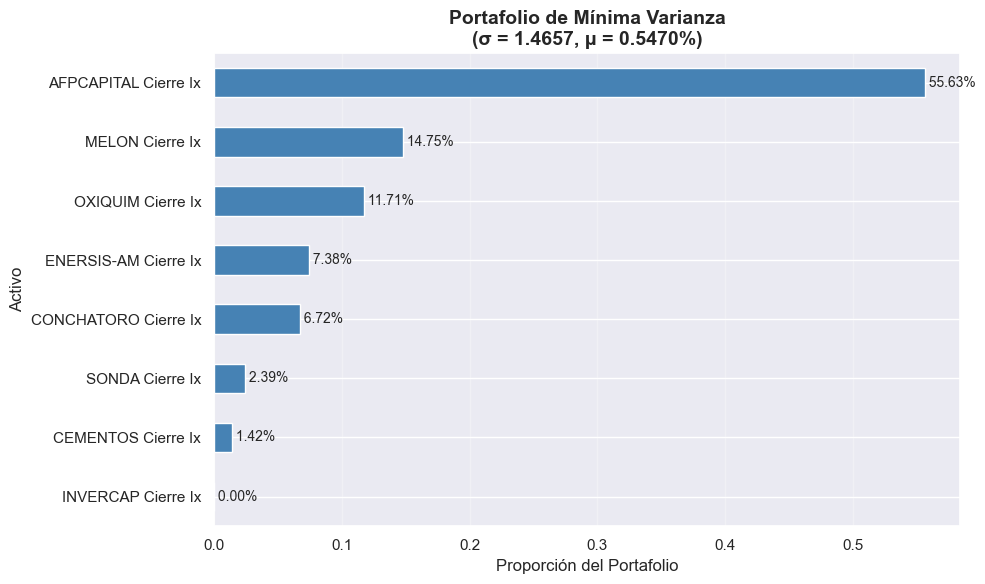

In [10]:
# Visualización del portafolio de mínima varianza
positions_to_plot = min_var_positions[min_var_positions > 1e-8].sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
positions_to_plot.plot.barh(ax=ax, color='steelblue')
ax.set_xlabel('Proporción del Portafolio')
ax.set_ylabel('Activo')
ax.set_title(f'Portafolio de Mínima Varianza\n(σ = {min_std:.4f}, μ = {mu.to_numpy() @ x_min_var.X:.4f}%)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Agregar porcentajes en las barras
for i, (index, value) in enumerate(positions_to_plot.items()):
    ax.text(value, i, f' {value*100:.2f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

Con el nivel mínimo de riesgo, podemos dibujar la frontera eficiente para distintos niveles de riesgo:

In [11]:
# Extraer la diagonal
diagonal = np.sqrt(np.diag(Sigma))

# Mejor índice en términos de retorno
indice_mayor_mu = np.argmax(mu)

riesgos = np.linspace(min_std, diagonal[indice_mayor_mu], 50)
retornos = np.zeros(riesgos.shape)
npos = np.zeros(riesgos.shape)

# ocultar la salida de log de Gurobi
m.params.OutputFlag = 0

# resolver el modelo para cada nivel de riesgo
for i, nivel_riesgo in enumerate(riesgos):
    # establecer el nivel de riesgo: lado derecho de la restricción de riesgo
    restriccion_riesgo.setAttr('QCRHS', nivel_riesgo**2)
    m.optimize()
    # almacenar datos
    retornos[i] = mu @ x.X
    npos[i] = len([xi for xi in x.X if xi > 1e-5])

A continuación, mostramos la frontera eficiente para este modelo: graficamos los rendimientos esperados (en el eje $y$) frente a la desviación estándar $\sqrt{x^\top\Sigma x}$ de los rendimientos esperados (en el eje $x$). También mostramos la relación entre el riesgo y el número de posiciones en el portafolio óptimo.

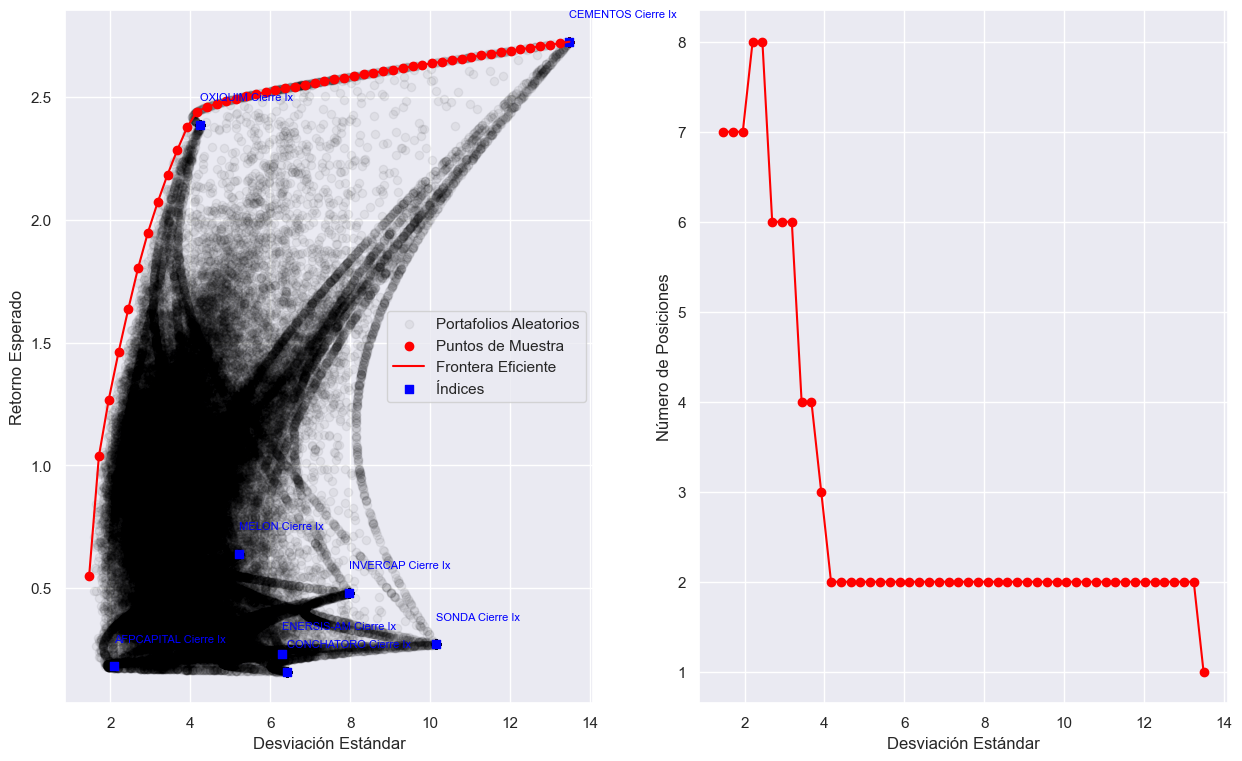

In [12]:
# Generación de portafolios
num_portfolios = 100000
num_indices = len(mu)

retornos_aleatorios = np.zeros(num_portfolios)
volatilidades_aleatorias = np.zeros(num_portfolios)

for i in range(num_portfolios):
    # Generar portafolios
    if np.random.rand() > 0.8:
        # Portafolios balanceados
        pesos = np.random.dirichlet(np.ones(num_indices) * np.random.uniform(0.1, 200), size=1)[0]
    else:
        # Portafolios Extremos
        pesos = np.zeros(num_indices)
        num_picked_assets = np.random.randint(1, num_indices)
        picked_assets = np.random.choice(num_indices, num_picked_assets, replace=False)
        pesos[picked_assets] = np.random.rand(num_picked_assets)
        pesos /= np.sum(pesos)  # Normalizar la suma

    # Calcular retorno esperado
    retornos_aleatorios[i] = np.dot(pesos, mu)

    # Calcular volatilidad
    portfolio_variance = np.dot(pesos.T, np.dot(Sigma, pesos))
    volatilidades_aleatorias[i] = np.sqrt(portfolio_variance)

index_names = list(mu.index)
index_returns = list(mu)
index_volatilities = np.sqrt(np.diag(Sigma))


fig, axs = plt.subplots(1, 2, figsize=(15, 9))

# Portafolios Randomizados
axs[0].scatter(x=volatilidades_aleatorias, y=retornos_aleatorios, marker="o", label="Portafolios Aleatorios", color="Black", alpha=0.05)

# La frontera eficiente
axs[0].scatter(x=riesgos, y=retornos, marker="o", label="Puntos de Muestra", color="Red")
axs[0].plot(riesgos, retornos, label="Frontera Eficiente", color="Red")

# Plot
axs[0].scatter(x=index_volatilities, y=index_returns, marker="s", color="Blue", label="Índices")
for i, name in enumerate(index_names):
    axs[0].annotate(name, (index_volatilities[i], index_returns[i]+0.1), fontsize=8, color="Blue")


axs[0].set_xlabel("Desviación Estándar")
axs[0].set_ylabel("Retorno Esperado")
axs[0].legend()

# El número de posiciones activas
axs[1].scatter(x=riesgos, y=npos, color="Red")
axs[1].plot(riesgos, npos, color="Red")
axs[1].set_xlabel("Desviación Estándar")
axs[1].set_ylabel("Número de Posiciones")

plt.show()

Como era de esperar, el número de posiciones abiertas disminuye a medida que permitimos más varianza; la optimización invertirá progresivamente en activos de alto riesgo, pero con altos rendimientos.